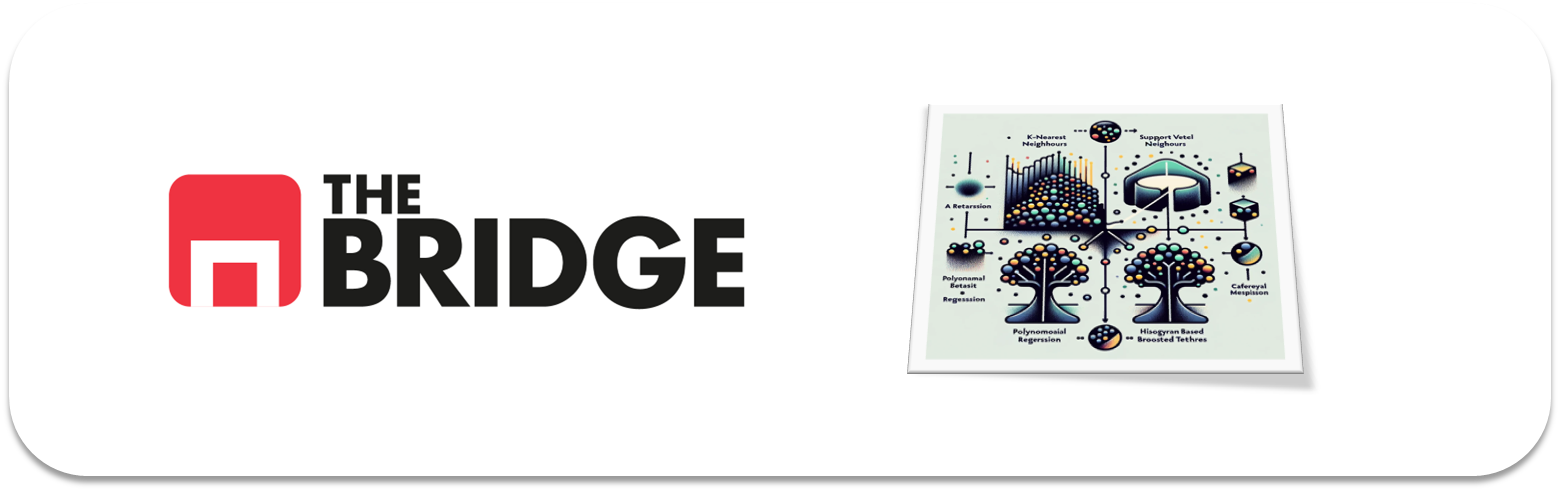

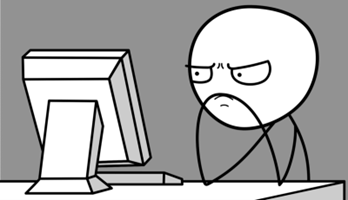

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bootcampviztools as bt
import toolbox_ML as tb

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor



### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

*Como pide en el problema, quieren un modelo que se equivoque de media en menos de 100 unidades por millón, medida en la que tienen registrada la presencia de Ozono, la métrica más conveniente sería **MAE** (Mean Absolute Error) ya que mide el error medio en las mismas unidades que la variable objetivo y me permitirá verificar fácilmente si el modelo cumple con este requisito.*

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [107]:
df_ozono = pd.read_csv('./data/air_contamination.csv')

In [108]:
df_ozono.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [109]:
df_ozono.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


In [110]:
tb.describe_df(df_ozono)

,COL_N,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,DATA_TYPE,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UNIQUE_VALUES,95,3245,428,3772,3772,2362,3518,1367,4407,4678,3367,4902,8987
3,CARDIN (%),1.06,36.09,4.76,41.95,41.95,26.27,39.13,15.2,49.02,52.03,37.45,54.52,99.96


*Descripción de las variables*:

- `CO(GT)`: Concentración de monóxido de carbono medida en el aire. --> **Numérica Discreta o Continua**
- `PT08.S1(CO)`: Salida del sensor 1 relacionado con la concentración de CO. --> **Numérica Continua**
- `NMHC(GT)`: Hidrocarburos no metánicos medidos en el aire. --> **Numérica Continua**
- `C6H6(GT)`: Concentración de benceno (C6H6), un compuesto tóxico. --> **Numérica Continua**
- `PT08.S2(NMHC)`: Salida del sensor 2 asociado a hidrocarburos no metánicos. --> **Numérica Continua**
- `NOx(GT)`: Concentración de óxidos de nitrógeno (NOx). --> **Numérica Continua**
- `PT08.S3(NOx)`: Salida del sensor 3 relacionado con los óxidos de nitrógeno. --> **Numérica Continua**
- `NO2(GT)`: Concentración de dióxido de nitrógeno (NO2). --> **Numérica Continua**
- `PT08.S4(NO2)`: Salida del sensor 4 asociado a NO2. --> **Numérica Continua**
- `PT08.S5(O3)`: Salida del sensor 5 que mide la concentración de ozono (O3) (**TARGET**). --> **Numérica Continua**
- `T`: Temperatura. --> **Numérica Continua**
- `RH`: Humedad relativa. --> **Numérica Continua**
- `AH`: Humedad absoluta. --> **Numérica Continua**

In [111]:
target = 'PT08.S5(O3)'

### Ejercicio 3: Split

Haz el split en train y test.

In [112]:
train_set, test_set = train_test_split(df_ozono, test_size=0.2, random_state=42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

<Axes: >

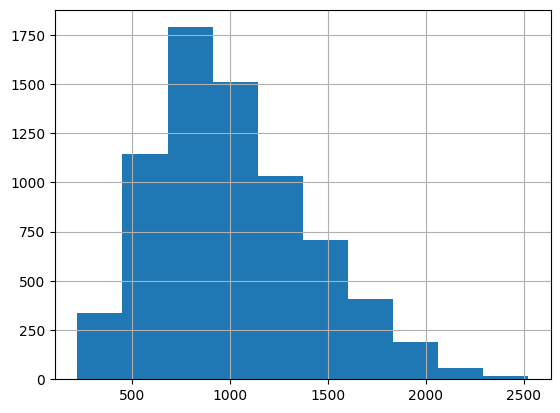

In [113]:
train_set[target].hist()

*No es una Gaussiana pero la varianza está estabilizada por lo que estos ante un problema de **Regresión Lineal***

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [114]:
corr = train_set.corr(numeric_only=True)[target]
np.abs(corr).sort_values(ascending=False)

PT08.S5(O3)      1.000000
PT08.S1(CO)      0.901005
PT08.S2(NMHC)    0.879959
C6H6(GT)         0.864269
PT08.S3(NOx)     0.794185
NOx(GT)          0.623100
PT08.S4(NO2)     0.590688
NO2(GT)          0.337581
RH               0.133955
CO(GT)           0.128110
NMHC(GT)         0.110077
AH               0.069113
T                0.032899
Name: PT08.S5(O3), dtype: float64

In [115]:
tb.get_features_num_regression(train_set, target, 0.01, 0.95)


Las correlaciones con las demás variables numéricas y "PT08.S5(O3)" son:

PT08.S5(O3)      1.000000
PT08.S1(CO)      0.901005
PT08.S2(NMHC)    0.879959
C6H6(GT)         0.864269
PT08.S3(NOx)     0.794185
NOx(GT)          0.623100
PT08.S4(NO2)     0.590688
NO2(GT)          0.337581
RH               0.133955
CO(GT)           0.128110
NMHC(GT)         0.110077
AH               0.069113
T                0.032899
Name: PT08.S5(O3), dtype: float64

Lista de variables numéricas que tiene correlación según el umbral dado en la función:
['PT08.S1(CO)', 'PT08.S2(NMHC)', 'C6H6(GT)', 'PT08.S3(NOx)', 'NOx(GT)', 'PT08.S4(NO2)', 'NO2(GT)', 'RH', 'CO(GT)', 'NMHC(GT)', 'AH', 'T']

Las features numéricas con una significancia del 95.0 % son:


['PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'C6H6(GT)',
 'PT08.S3(NOx)',
 'NOx(GT)',
 'PT08.S4(NO2)',
 'NO2(GT)',
 'RH',
 'CO(GT)',
 'NMHC(GT)',
 'AH',
 'T']

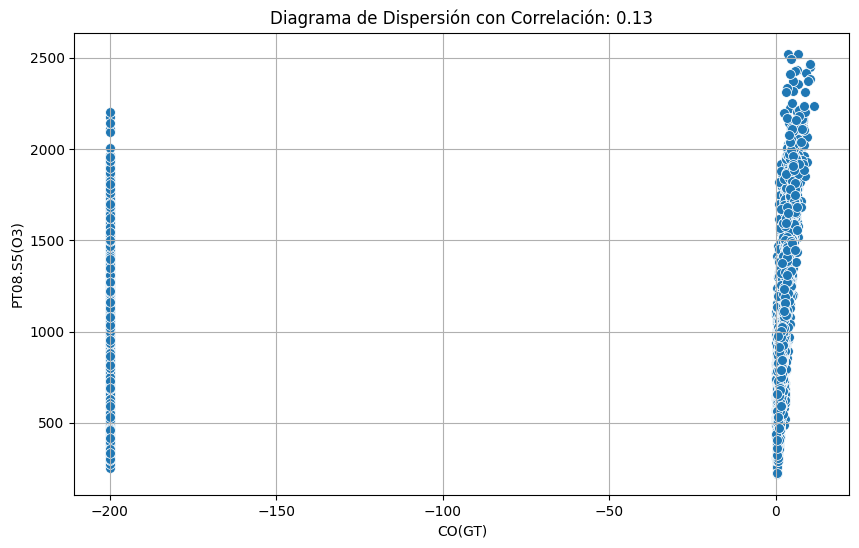

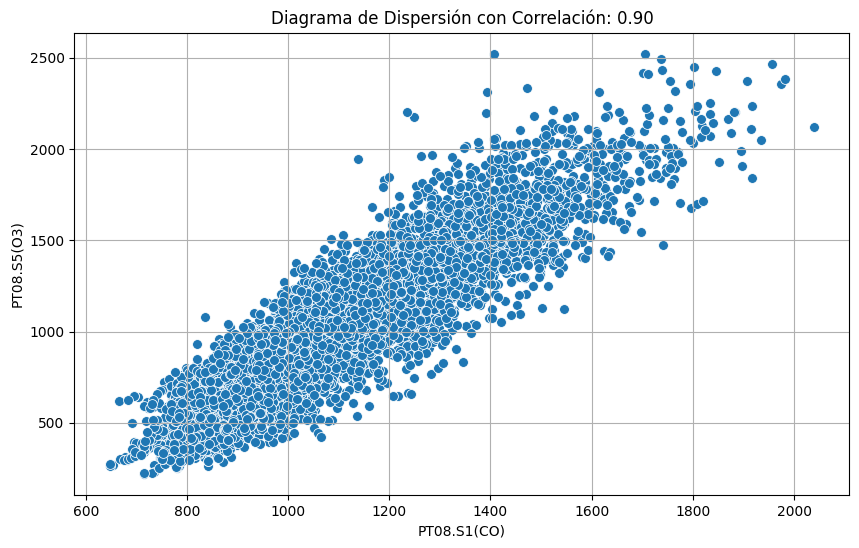

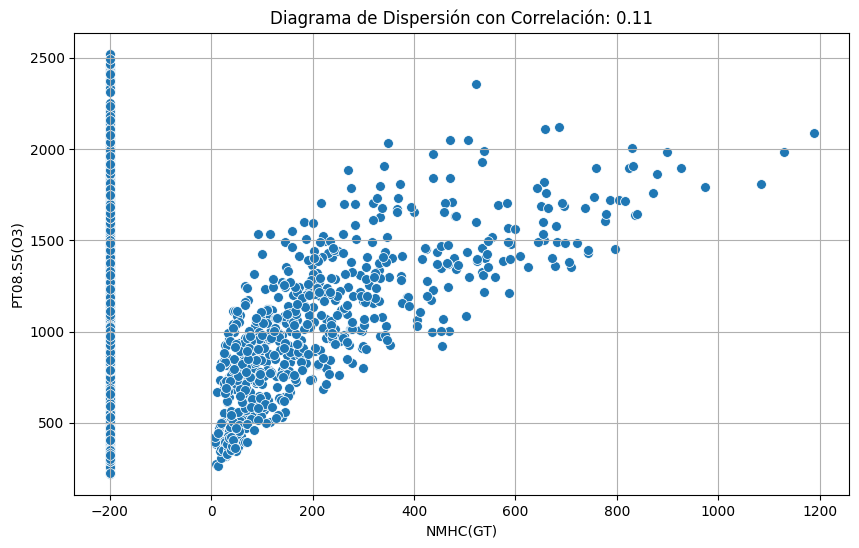

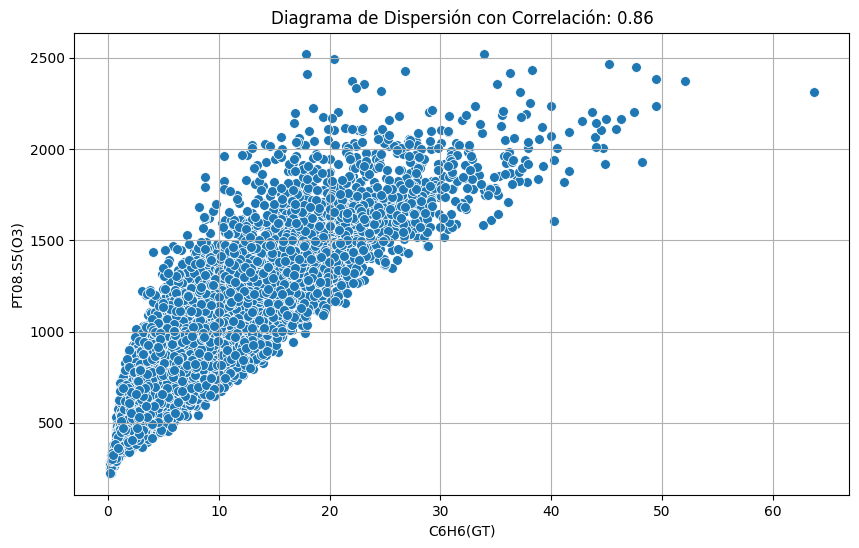

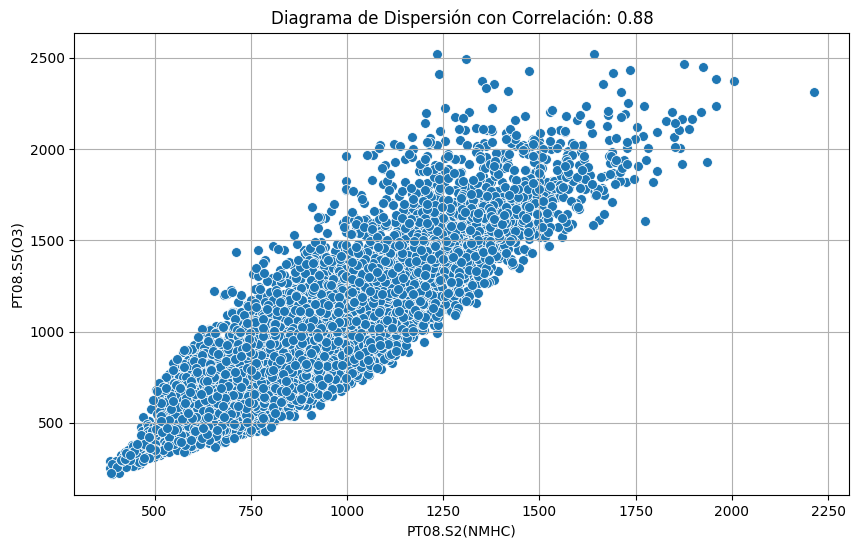

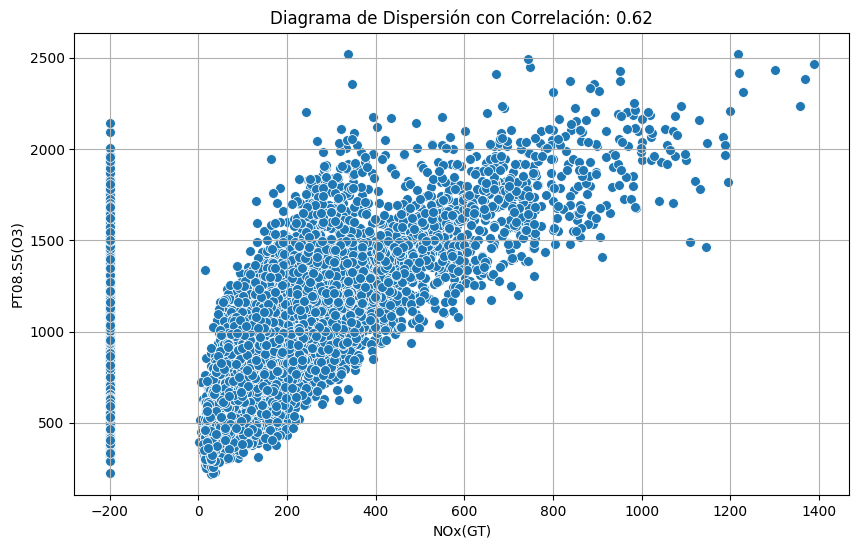

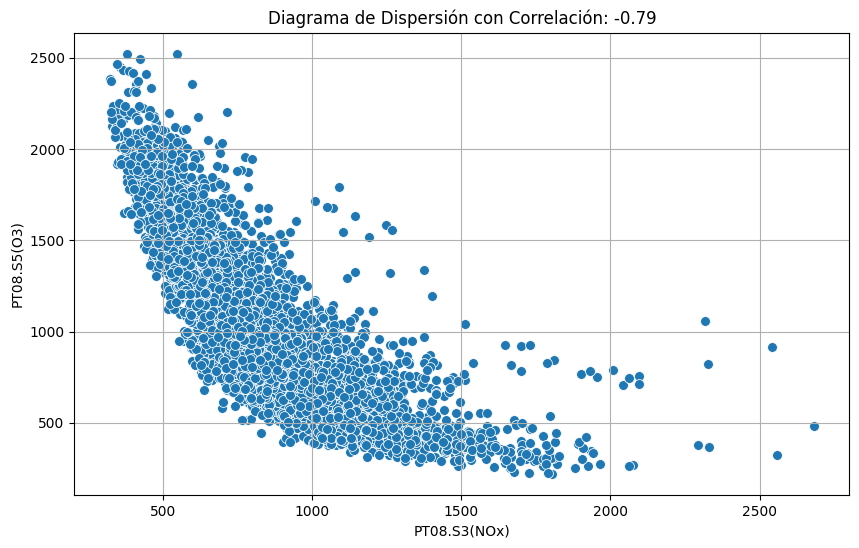

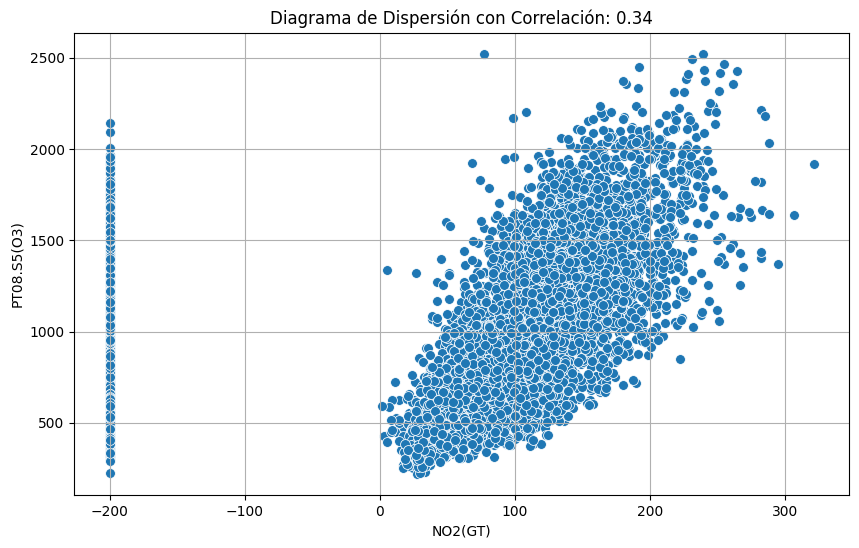

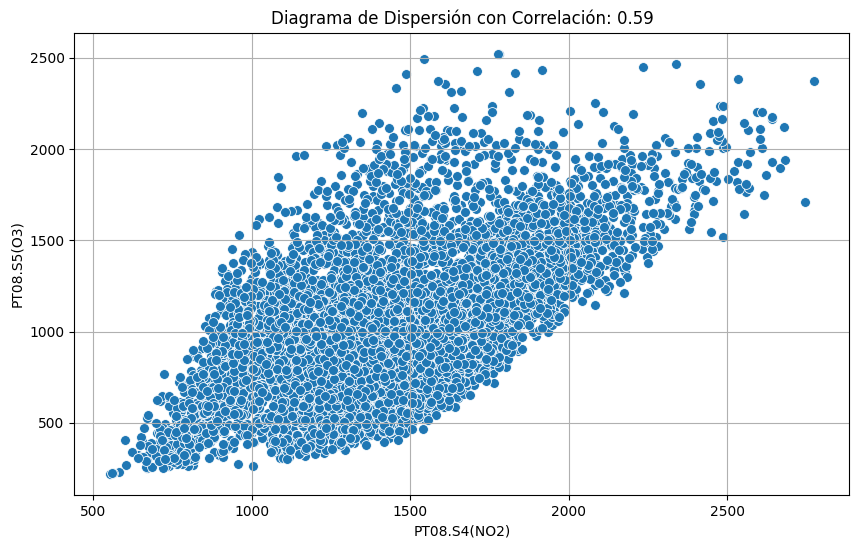

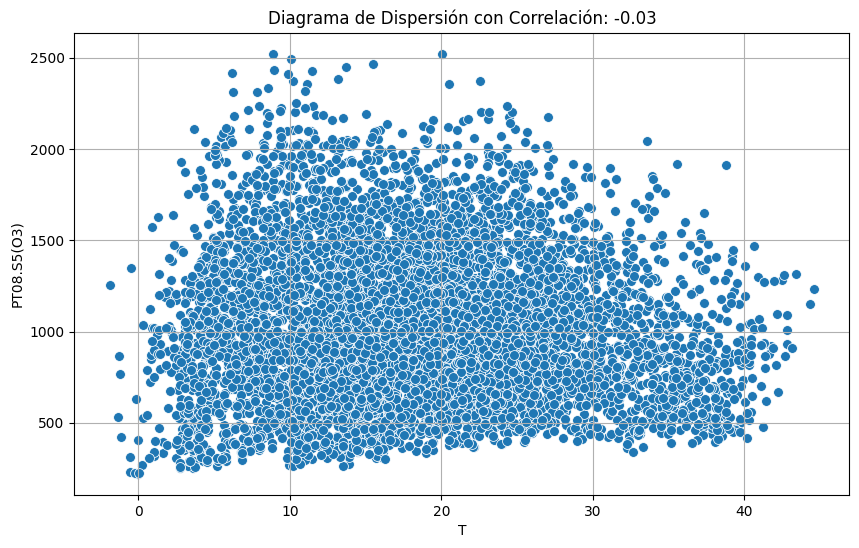

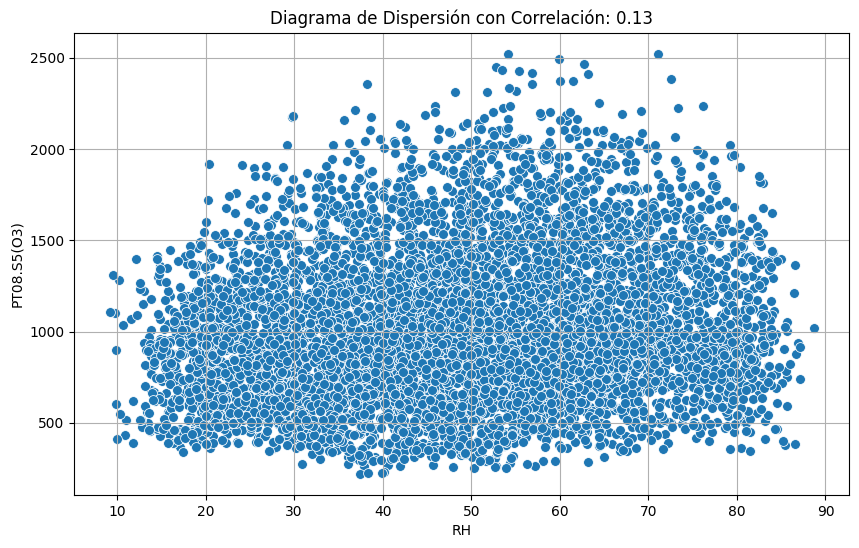

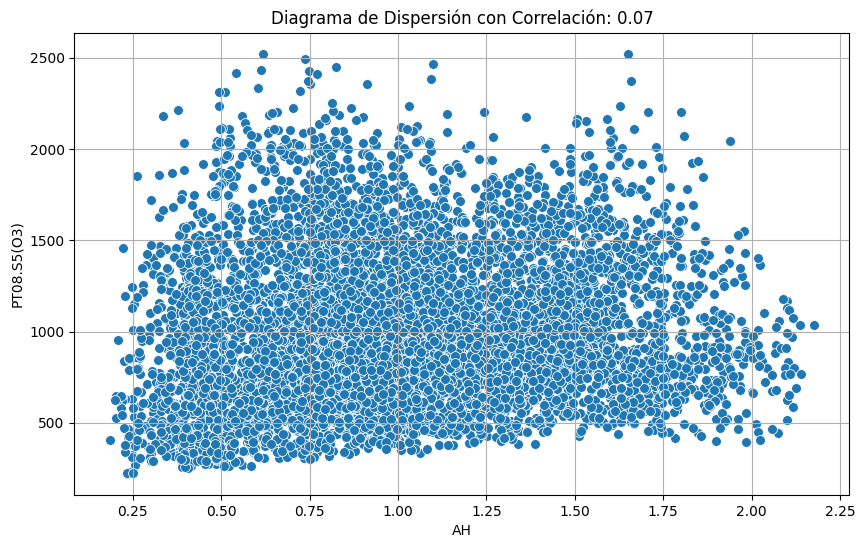

In [116]:
for col in train_set.columns:
    if col != target:
        bt.grafico_dispersion_con_correlacion(train_set, col, target, mostrar_correlacion=True)

In [117]:
train_set['CO(GT)'].unique()

array([-2.00e+02,  2.50e+00,  1.10e+00,  1.90e+00,  2.80e+00,  1.40e+00,
        7.00e-01,  4.00e+00,  1.60e+00,  3.60e+00,  1.50e+00,  2.10e+00,
        4.70e+00,  5.00e+00,  1.00e+00,  5.00e-01,  4.00e-01,  4.40e+00,
        8.00e-01,  1.80e+00,  3.80e+00,  1.30e+00,  5.50e+00,  2.70e+00,
        3.70e+00,  5.30e+00,  6.00e-01,  1.00e-01,  2.90e+00,  3.00e-01,
        3.10e+00,  2.60e+00,  2.40e+00,  9.00e-01,  2.00e+00,  3.50e+00,
        2.20e+00,  3.30e+00,  3.20e+00,  1.15e+01,  1.20e+00,  5.70e+00,
        3.90e+00,  3.00e+00,  4.10e+00,  1.70e+00,  5.60e+00,  2.30e+00,
        4.50e+00,  2.00e-01,  4.90e+00,  6.30e+00,  3.40e+00,  5.10e+00,
        4.80e+00,  7.20e+00,  5.20e+00,  6.60e+00,  7.50e+00,  4.20e+00,
        8.00e+00,  6.10e+00,  6.50e+00,  4.60e+00,  4.30e+00,  1.02e+01,
        7.90e+00,  7.00e+00,  6.70e+00,  5.80e+00,  5.90e+00,  8.70e+00,
        7.30e+00,  5.40e+00,  6.00e+00,  6.20e+00,  7.70e+00,  6.90e+00,
        6.40e+00,  6.80e+00,  9.10e+00,  7.40e+00, 

*Según esta función, si el umbral es bajo, aparece que todos tienen una significancia del 95%*

*Como esta función no es muy fiable, haré una comparación de manera visualizada*

*Observamos lo siguiente*:

- `CO(GT)` se puede tratar como una categórica
- Relación significativa con: `PT08.S1(CO)`, `C6H6(GT)`, `PT08.S2(NMHC)`, `NOx(GT)`, `PT08.S3(NOx)`, `NO2(GT)`, `PT08.S4(NO2)`
- Poca relación: `NMHC(GT)`, `T`, `RH`, `AH`
- Datos faltantes valorados como -200: `CO(GT)`, `NMHC(GT)`, `NOx(GT)`, `NO2(GT)`

*LIMPIEZA DE **TRAIN***

*Primero voy a analizar las variables con -200*

In [118]:
var_200 = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)']

for var in var_200:
    valor = train_set[var].value_counts(True)[-200]
    print(f'Para {var} --> {round(valor * 100)} % de -200')

Para CO(GT) --> 19 % de -200
Para NMHC(GT) --> 90 % de -200
Para NOx(GT) --> 18 % de -200
Para NO2(GT) --> 18 % de -200


*`NMHC(GT)` al tener un altísimo porcentaje de valores de -200, la descarto ya que si convierto esos valores sería sesgar muchísimos los datos y como consecuencia los resultados sería erróneos.*

*Las demás las voy a convertir en su media o en la mediana, dependiendo de la distribución*

In [119]:
var_200.remove('NMHC(GT)')

In [120]:
train_set[var_200].describe()

,CO(GT),NOx(GT),NO2(GT)
count,7192.000000,7192.000000,7192.000000
mean,-35.402183,162.499027,55.716838
std,78.598763,251.498158,126.820691
min,-200.000000,-200.000000,-200.000000
25%,0.600000,47.000000,51.000000
50%,1.400000,138.000000,95.000000
75%,2.500000,280.000000,131.000000
max,11.500000,1389.000000,321.600000


In [121]:
# Como hay casi un 20% mejor realizar la mediana ya que sino la media se vería afectada por los valores negativos
median_co = train_set['CO(GT)'].median()
median_nox = train_set['NOx(GT)'].median()
median_no2 = train_set['NO2(GT)'].median()

medians = [median_co, median_nox, median_no2]

#Tranformo en Train y Test
for col,median in zip(var_200, medians):
    print(col, '-->', median)
    train_set.loc[train_set[col] == -200, col] = median
    test_set.loc[test_set[col] == -200, col] = median

train_set[var_200].describe()

CO(GT) --> 1.4
NOx(GT) --> 138.0
NO2(GT) --> 95.0


,CO(GT),NOx(GT),NO2(GT)
count,7192.000000,7192.000000,7192.000000
mean,1.982272,222.795745,108.465726
std,1.318786,190.465656,43.387006
min,0.100000,2.000000,2.000000
25%,1.200000,111.000000,84.000000
50%,1.400000,138.000000,95.000000
75%,2.500000,280.000000,131.000000
max,11.500000,1389.000000,321.600000


### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

*Una vez hecha la limpieza, seleccionamos las **Features** y realizamos las transformaciones necesarias.*

*Descartamos por baja correlación y por valores missings: `NMHC(GT)`, `T`, `RH`, `AH`*

In [122]:
features = [col for col in train_set.columns if col != target and col != 'NMHC(GT)' and col != 'T' and col != 'RH' and col != 'AH']
features

['CO(GT)',
 'PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)']

In [135]:
modelos = ['RandomForestRegressor', 'XGBoostRegressor', 'LGBMRegressor']

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

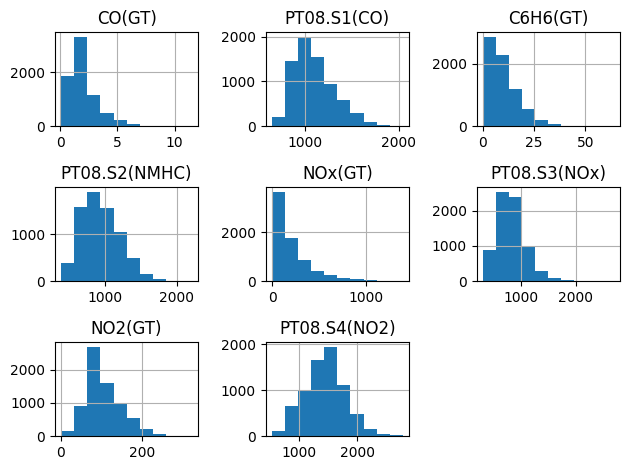

In [124]:
# Vemos los histogramas
train_set[features].hist()
plt.tight_layout()

In [125]:
# Estas son las variables que necesitarían una tranformación logaritmica
features_log = [col for col in features if col != 'NO2(GT)' and col != 'PT08.S4(NO2)']

# Me aseguro que no tengan valores 0 ni menores para aplicar a estas una constante
train_set[features_log].min()

CO(GT)             0.100000
PT08.S1(CO)      647.250000
C6H6(GT)           0.149048
PT08.S2(NMHC)    383.250000
NOx(GT)            2.000000
PT08.S3(NOx)     322.000000
dtype: float64

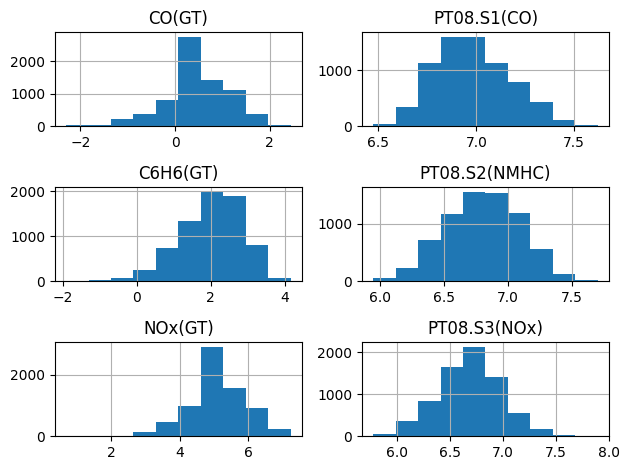

In [126]:
for col in features_log:
    train_set[col] = np.log(train_set[col])

In [127]:
for col in features_log: # Aplico en Test
    test_set[col] = np.log(test_set[col])

In [129]:
train_set[features].describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2)
count,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000
mean,0.478507,6.981465,2.003658,6.800963,5.095744,6.686842,108.465726,1454.166956
std,0.666889,0.191236,0.840485,0.286003,0.807450,0.298996,43.387006,344.351668
min,-2.302585,6.472733,-1.903489,5.948688,0.693147,5.774552,2.000000,551.000000
25%,0.182322,6.838673,1.475274,6.594328,4.709530,6.494132,84.000000,1226.687500
50%,0.336472,6.965316,2.097382,6.808073,4.927254,6.694407,95.000000,1462.250000
75%,0.916291,7.111308,2.625108,7.012397,5.634790,6.881411,131.000000,1668.250000
max,2.442347,7.620583,4.154835,7.702556,7.236339,7.894598,321.600000,2775.000000


*Observo que los datos son muy diferentes entre variables por lo que voy a **estandarizar** los datos para que tengan una media de 0 y una desvianción estándar de 1*

In [131]:
scaler = StandardScaler()

train_set[features] = scaler.fit_transform(train_set[features])
test_set[features] = scaler.transform(test_set[features])

In [132]:
train_set[features].describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2)
count,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03
mean,-9.286849e-17,8.140812e-16,2.054962e-16,6.797183e-16,-8.852145e-16,-1.106518e-16,-6.322961e-17,-1.289291e-16
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00
min,-4.170540e+00,-2.660422e+00,-4.649003e+00,-2.980158e+00,-5.452848e+00,-3.051387e+00,-2.454033e+00,-2.622986e+00
25%,-4.441618e-01,-7.467323e-01,-6.287096e-01,-7.225418e-01,-4.783463e-01,-6.445675e-01,-5.639344e-01,-6.606481e-01
50%,-2.129966e-01,-8.445005e-02,1.115187e-01,2.486253e-02,-2.086843e-01,2.530428e-02,-3.103847e-01,2.347486e-02
75%,6.565021e-01,6.790155e-01,7.394448e-01,7.393231e-01,6.676361e-01,6.507866e-01,5.194145e-01,6.217421e-01
max,2.944984e+00,3.342271e+00,2.559624e+00,3.152609e+00,2.651240e+00,4.039646e+00,4.912740e+00,3.835976e+00


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [133]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [136]:
rf_rg = RandomForestRegressor(max_depth=5)
xgb_rg = XGBRegressor()
lgb_rg = LGBMRegressor(verbose = -100)

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [139]:
instancias = [rf_rg, xgb_rg, lgb_rg]

for models,nombre in zip(instancias, modelos):
    cv_model = cross_val_score(models, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mean_mae = -cv_model.mean() # Lo pongo en negativo ya que error está en negativo
    print(f'MAE medio para {nombre} --> {mean_mae}')

MAE medio para RandomForestRegressor --> 109.33095472883033
MAE medio para XGBoostRegressor --> 96.26475489532092
MAE medio para LGBMRegressor --> 94.52610942377059


*En este primer entrenamiento con CV, el mejor error lo obtendría **LGBRegressor***

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [141]:
params_grid = {
    'num_leaves': [31,63,127],
    'max_depth': [10,20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimator': [100,200,300]
}

lgb_grid = GridSearchCV(lgb_rg, param_grid=params_grid, scoring='neg_mean_absolute_error', cv=5)

lgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(verbose=-100),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [10, 20], 'n_estimator': [100, 200, 300],
                         'num_leaves': [31, 63, 127]},
             scoring='neg_mean_absolute_error')

In [142]:
lgb_grid.best_estimator_

LGBMRegressor(max_depth=20, n_estimator=100, num_leaves=127, verbose=-100)

In [143]:
lgb_grid.best_score_

-91.97408387610484

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [149]:
y_pred = lgb_grid.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f'MAE para test --> {mae}')

MAE para test --> 89.16160777744037


### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.